In [1]:
# import modules as usual
import os
import glob

import numpy as np

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# path of files
path_positive_1 = '../eskin_data/yamamoto/throw/'
path_negative_1 = '../eskin_data/yamamoto/others/'

path_positive_2 = '../eskin_data/zennra/throw/'
path_negative_2 = '../eskin_data/zennra/others/'

In [3]:
# extract the moment of throwing based on accel values
def extract_action(df):
    df = df.reset_index()
    
    mom_action = int((np.argmax(abs(df.accelX))+ np.argmax(abs(df.accelY))+ np.argmax(abs(df.accelZ)))/3)
    df = df.ix[mom_action-90:mom_action+90] 
    
    df.index = df.time
    df.drop(["time"], axis=1, inplace=True)
    
    return df.as_matrix()

In [4]:
def load_positive_data(path):
    path = os.path.join(path, '*.csv')
    files = glob.glob(path)
    
    X_positives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        df = extract_action(df)
        
        X_positives.append(df)
        
    X_positives = np.array(X_positives)
    y_positives = np.ones(len(X_positives))
        
    return X_positives, y_positives

In [5]:
def load_negative_data(path, num_clip=100, random_state=71):
    np.random.seed(random_state)
    
    path = os.path.join(path, '*.csv')
    files = glob.glob(path)
    
    X_negatives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        for i in range(num_clip):
            start = np.random.choice(range(len(df)-180))
            
            df_extracted = df.iloc[start:start+180].as_matrix()
            X_negatives.append(df_extracted)
        
    X_negatives = np.array(X_negatives)
    y_negatives = np.zeros(len(X_negatives))
        
    return X_negatives, y_negatives

In [6]:
def resize_matrix(X, size = (20, 20), flatten=False):
    X_resized = []
    
    for i in range(len(X)):
        X_ = X[i] /1.
        X_ = cv2.resize(X_, size, interpolation = cv2.INTER_LINEAR)
    
        if flatten == True: # True for XGBoost etc., False for CNN (Convolutional Newral Networks) 
            X_ = X_.ravel()
            
        X_resized.append(X_)
        
    X_resized = np.array(X_resized)
    
    return X_resized

In [7]:
# １人目（山本）のモーションデータを読み込む
X_positives_1, y_positives_1 = load_positive_data(path_positive_1)
X_negatives_1, y_negatives_1 = load_negative_data(path_negative_1, num_clip=500)  # random 500 clops from negative data

# check the shape of positive data
print(X_positives_1.shape, y_positives_1.shape)

# check the shape of negative data
print(X_negatives_1.shape, y_negatives_1.shape)

X_positives_1 = resize_matrix(X_positives_1, flatten=True)
X_negatives_1 = resize_matrix(X_negatives_1, flatten=True)

X_1 = np.concatenate((X_positives_1, X_negatives_1), axis=0)
y_1 = np.concatenate((y_positives_1, y_negatives_1), axis=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


((100, 181, 20), (100,))
((2000, 180, 20), (2000,))


In [8]:
# ２人目（武井氏 aka 全裸）のモーションデータを読み込む
X_positives_2, y_positives_2 = load_positive_data(path_positive_2)
X_negatives_2, y_negatives_2 = load_negative_data(path_negative_2, num_clip=500)  # random 500 clops from negative data

# check the shape of positive data
print(X_positives_2.shape, y_positives_2.shape)

# check the shape of negative data
print(X_negatives_2.shape, y_negatives_2.shape)

X_positives_2 = resize_matrix(X_positives_2, flatten=True)
X_negatives_2 = resize_matrix(X_negatives_2, flatten=True)

X_2 = np.concatenate((X_positives_2, X_negatives_2), axis=0)
y_2 = np.concatenate((y_positives_2, y_negatives_2), axis=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


((91,), (91,))
((1000, 180, 20), (1000,))


In [9]:
# 山本データで学習して、武井データに対して予測を行う。AUCは0.98とかなり良好。
clf_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, 
                        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, 
                        min_child_weight=1, missing=None, n_estimators=100, nthread=-1, 
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

clf_xgb.fit(X_1, y_1)
probs = clf_xgb.predict_proba(X_2)[:,1]
score = roc_auc_score(y_2, probs)
print(score)

0.983637362637


In [10]:
# 武井データで学習して、山本データに対して予測を行う。AUCは0.84と落ちはしたが、まぁ悪くはない。
clf_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, 
                        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, 
                        min_child_weight=1, missing=None, n_estimators=100, nthread=-1, 
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

clf_xgb.fit(X_2, y_2)
probs = clf_xgb.predict_proba(X_1)[:,1]
score = roc_auc_score(y_1, probs)
print(score)

0.838185


In [11]:
X = np.concatenate((X_1, X_2), axis=0)
y = np.concatenate((y_1, y_2), axis=0)

In [12]:
df_ref = pd.read_csv("../eskin_data/yamamoto/throw/eskin131418286838246619.csv", index_col=0)

In [13]:
clf_xgb.fit(X, y)

feature_importance = clf_xgb.feature_importances_

In [14]:
df_imp = DataFrame(feature_importance.reshape(20,20), index=[str(x * 0.15) + "_msec" for x in range(20)], columns=df_ref.columns)

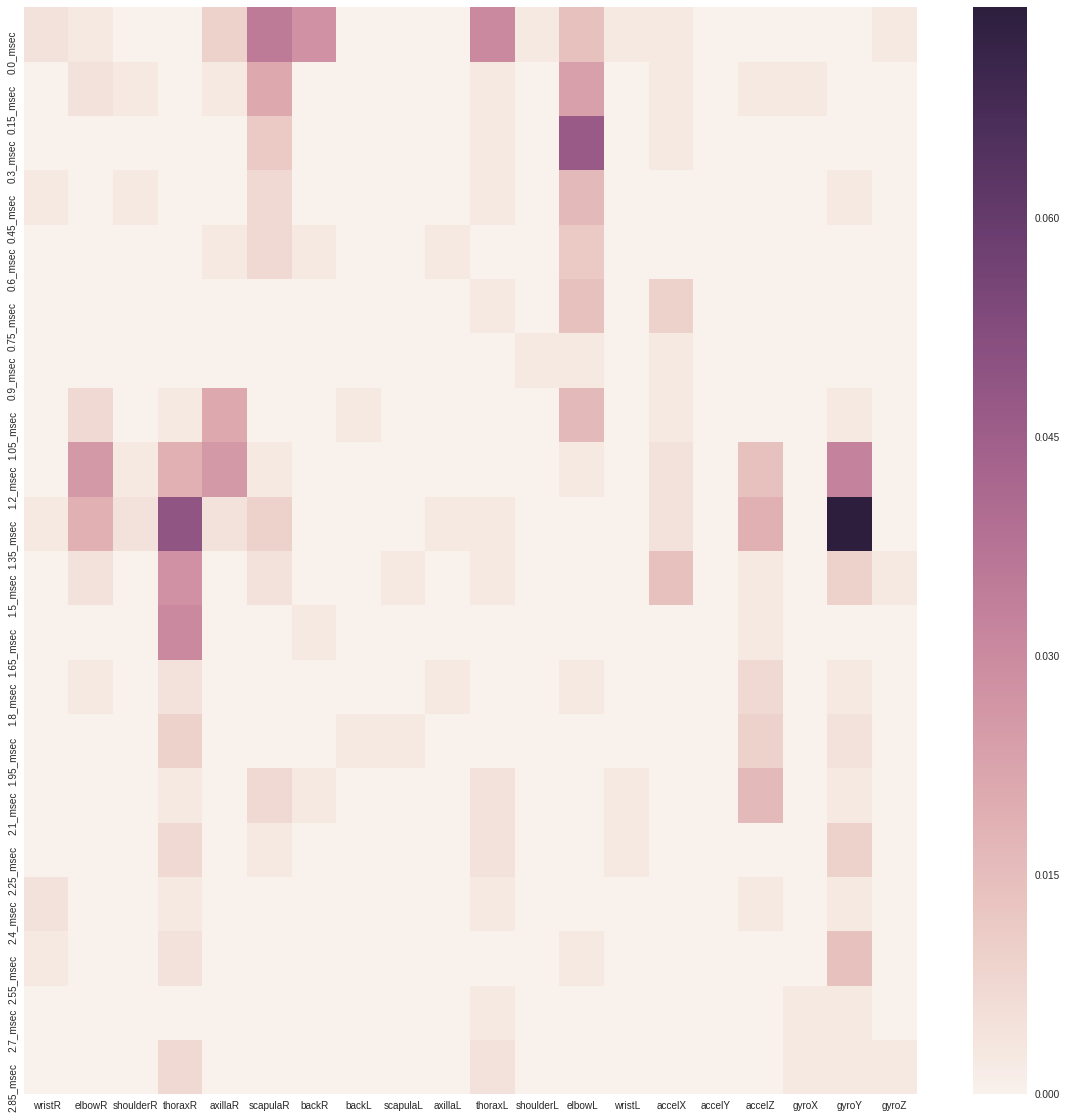

In [15]:
# show heatmap of feature importances.
plt.figure(figsize=[20,20])
sns.heatmap(df_imp)
plt.show()